# Applications of LSTM to the Prediction of Stock Market

Date: Febrary 2023 

## 摘要

准确预测一只股票的涨跌趋势对我们在股市的成功起着重要作用。LSTM(Long short-term memory)是一种特殊的RNN，是一种用于处理序列数据的神经网络，主要可以解决长序列训练过程中的梯度消失和梯度爆炸问题。简单来说，就是相比普通的RNN，LSTM能够在更长的序列中有更好的表现。在本文中，我们研究了 LSTM（使用Keras Python包）在股票每日价格预测中的应用。同时，我们将采用 CNN 来完成这一任务，并将其与 LSTM 进行比较。最后我们发现，LSTM 在完成时间序列类型任务的时候有着很不错的表现。


## 准备数据集


第一步是获取股票数据，并将其加载到内存中。我们将从 Yahoo Finance 获取股票数据。Yahoo Finance 是一个丰富的金融市场数据和工具资源，我们可以使用 yfinance 库来从该网站下载股票数据。

In [93]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
import yfinance as yf
# For time stamps
from datetime import datetime
import pandas as pd
import numpy as np

# as an example, we'll use 'Google' for this analysis
ticker = 'GOOG'

# three years
end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

# download data from Yahoo Finance
stock_data = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


为了方便之后的数据获取，我们将其封装为一个函数

In [95]:
def get_data_yahoo(ticker, years):
  end = datetime.now()
  start = datetime(end.year - years, end.month, end.day)
  stock_data = yf.download(ticker, start, end)
  return stock_data

## 数据分析

In [96]:
# print last 15 records
print(stock_data.tail(15))

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-31   97.860001   99.910004   97.790001   99.870003   99.870003   
2023-02-01   99.739998  102.190002   98.419998  101.430000  101.430000   
2023-02-02  106.790001  108.820000  106.540001  108.800003  108.800003   
2023-02-03  103.510002  108.019997  103.300003  105.220001  105.220001   
2023-02-06  102.684998  104.699997  102.209999  103.470001  103.470001   
2023-02-07  103.629997  108.669998  103.547997  108.040001  108.040001   
2023-02-08  102.690002  103.580002   98.455002  100.000000  100.000000   
2023-02-09  100.540001  100.610001   93.860001   95.459999   95.459999   
2023-02-10   95.739998   97.019997   94.529999   94.860001   94.860001   
2023-02-13   95.010002   95.349998   94.050003   95.000000   95.000000   
2023-02-14   94.660004   95.175003   92.650002   94.949997   94.949997   
2023-02-15   94.739998   97.339996   9


观察打印出来的数据，我们可以发现日期是数据的索引。其他几列的含义如下：
* Open - 当日股票开盘时的价格
* High - 当日股票的最高价格
* Low - 当日股票的最低价格
* Close - 当日收盘时的价格
* Adj Close - 调整后的收盘价
* Volume - 当日股票成交量  

另外，注意到记录中缺少周末的数据，这也符合股市的规则。

### 描述性统计信息

DataFrame 支持使用 describe() 生成描述性统计信息。描述性统计包括汇总数据集分布的中心趋势、分散度和形状的统计，不包括NaN值。

In [97]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02
mean,105.872270,107.162517,104.653729,105.916476,105.916476,3.061556e+07
std,26.078667,26.152655,25.900014,26.009143,26.009143,1.350339e+07
min,52.825500,53.566002,50.676800,52.831001,52.831001,6.700955e+06
25%,86.721123,87.788877,85.897062,86.799625,86.799625,2.183768e+07
50%,104.381248,106.138676,103.523998,104.915001,104.915001,2.724200e+07
75%,129.871372,130.934311,127.521626,129.243504,129.243504,3.512000e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,9.779860e+07


可以发现，过去三年仅有 756 天的股票数据，这是由于周末是没有数据记录的。另外还可以发现，该股票的股价过去一年在[50.676800, 152.100006] 这个区间波动

同样的，我们还可以使用 info() 来获取 DataFrame 的数据信息

In [98]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2020-02-21 to 2023-02-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       756 non-null    float64
 1   High       756 non-null    float64
 2   Low        756 non-null    float64
 3   Close      756 non-null    float64
 4   Adj Close  756 non-null    float64
 5   Volume     756 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.3 KB


### 收盘价


收盘价是股票在正常交易日的最后交易的价格，往往股票的收盘价会被投资者用做跟踪其长期表现的标准基准。因此，我们需要重点关注收盘价(通常关注调整后的收盘价)。

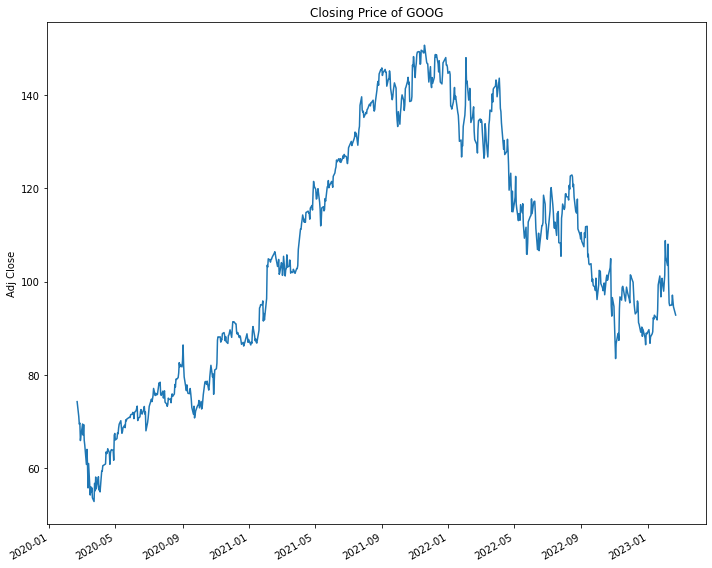

In [99]:
import matplotlib.pyplot as plt

# see a historical view of the closing price
plt.figure(figsize=(10, 8))

stock_data['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of {ticker}")
    
plt.tight_layout()

### 成交量

股票交易量是指每日开盘和收盘之间交易的股票数量。交易量以及交易量随时间的变化是股票技术交易者以及广大股民的重要参考指标。

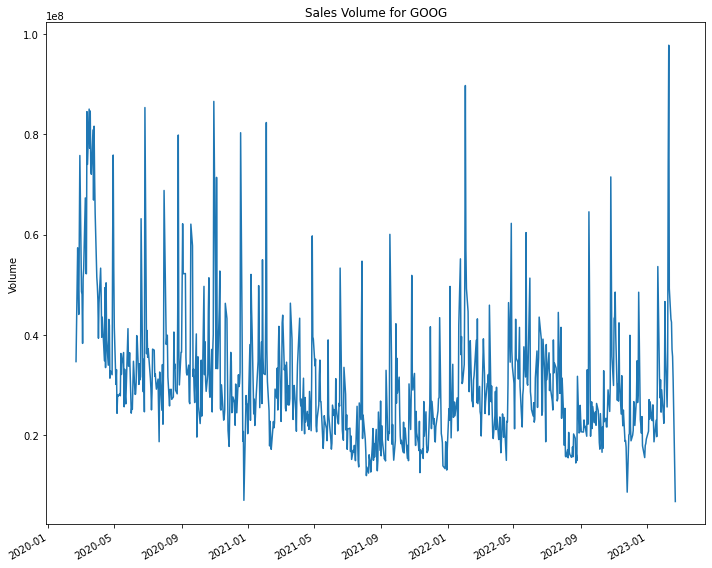

In [100]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(10, 8))

stock_data['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Sales Volume for {ticker}")
    
plt.tight_layout()

可以看出，在2020-05 到 2021-09 期间，谷歌的股价经历了持续不小幅度的上涨。在2022-01 到 2023-01 期间，股票价格持续有所下跌。

### 平均移动线

移动平均线（MA）是一种简单的技术分析工具，通过创建不断更新的平均价格来平滑价格数据。平均值是在特定的时间段内得出的，例如10分钟、20分钟、30分钟或交易者选择的任何时间段。

<Figure size 1440x1080 with 0 Axes>

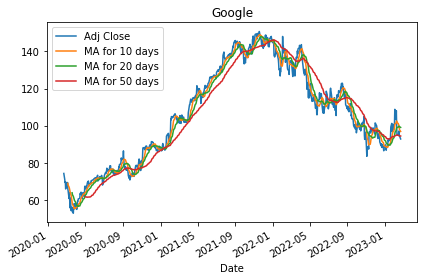

In [101]:
ma_day = [10, 20, 50]

for ma in ma_day:
  column_name = f"MA for {ma} days"
  stock_data[column_name] = stock_data['Adj Close'].rolling(ma).mean()

plt.figure(figsize=(20, 15)) 
stock_data[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title("Google")

plt.tight_layout()

我们在图中看到，测量移动平均线的最佳值是10天和20天，而50天的 MA 和收盘价拟合的效果明显差很多。这是由于10天和20天的MA噪声很少，相对50天而言，仍然是在较少噪声的情况下捕捉数据中的趋势，因此和收盘价高度拟合。

### 每日收益

前面我们已经做了一些基础的数据分析，接下来需要分析购买股票的风险。  
为了做到这一点，我们需要更仔细地观察股票的每日变化，而不仅仅是它的绝对价值。因此，我们关注Google的每日收益

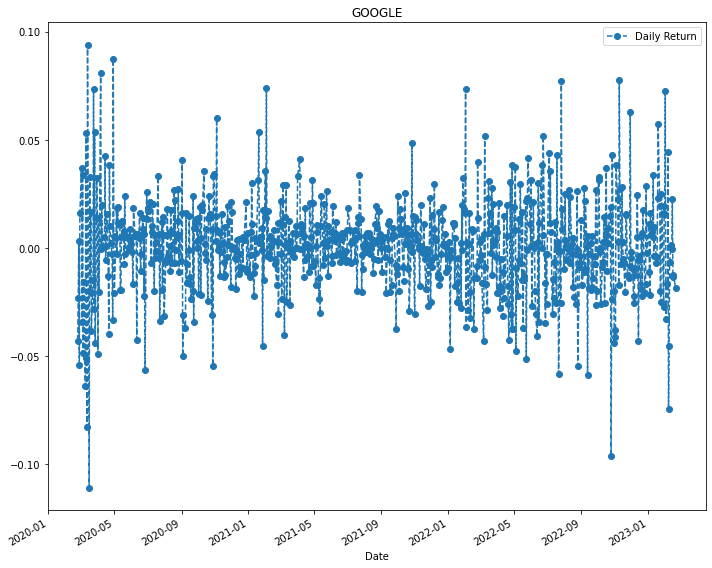

In [102]:
# plot the daily return percentage
plt.figure(figsize=(10, 8)) 

stock_data['Daily Return'] = stock_data['Adj Close'].pct_change()
stock_data['Daily Return'].plot(legend=True, linestyle='--', marker='o')

plt.title('GOOGLE')
plt.tight_layout()

## 模型训练

### 数据集划分 & 预处理

我们还是以 Google 的股票为例，来展示我们的模型效果。同时我们会将其封装好，只需要改变股票的名称，就可以重训练，从而无需对每个不同的股票都重新编码。  
我们使用前面封装好的获取数据集的接口来拿到 Google 过去 10 年的数据。

In [103]:
stock_data = get_data_yahoo("GOOG", 10)
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2013-02-21  19.875502  20.061056  19.706635  19.813982  19.813982  140781714
2013-02-22  19.906883  19.956448  19.770893  19.918093  19.918093   82463941
2013-02-25  19.982599  20.134781  19.688454  19.695427  19.695427   92501423
2013-02-26  19.800781  19.824444  19.536772  19.679485  19.679485   88430220
2013-02-27  19.795799  20.043621  19.703896  19.919836  19.919836   81347773


通过作图，可以大致看出 Google 过去 10 年的股价变化趋势

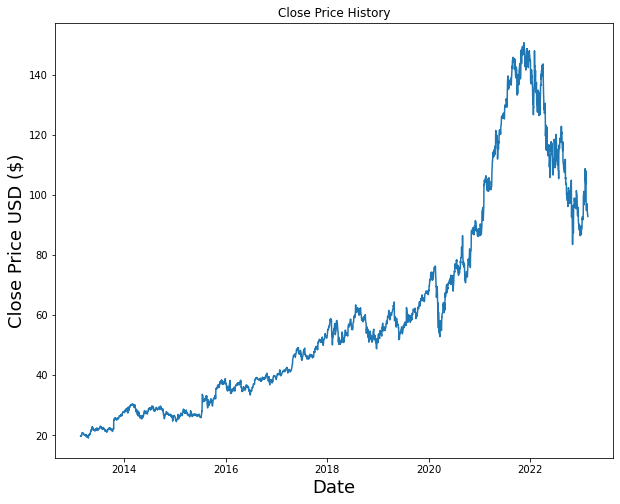

In [104]:
plt.figure(figsize=(10, 8))
plt.title('Close Price History')
plt.plot(stock_data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

为了之后的模型训练，我们需要将这 10 年的数据划分为 训练集和测试集。另外，根据前面的数据分析，我们认为仅需考虑收盘价格即可。

In [105]:
# Create a new dataframe with only the 'Close column 
data = stock_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
print(len(dataset))
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * 0.9))

2518


接下来，我们需要对数据进行简单的预处理，这里选择对其进行 MinMax 操作，放缩到[0,1]之间

In [106]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
print(scaled_data)

[[0.00560449]
 [0.0063954 ]
 [0.00470384]
 ...
 [0.58271023]
 [0.57366991]
 [0.56026139]]


最后，我们准备好训练集和测试集，以供之后的模型进行学习训练

In [107]:
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []
# choose 30 for MA
MA = 30
for i in range(MA, len(train_data)):
    # we use MA consecutive days of data to predict next day
    x_train.append(train_data[i-MA:i, 0])
    y_train.append(train_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


# Create the testing data set
# Create a new array containing scaled values
test_data = scaled_data[training_data_len - MA: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(MA, len(test_data)):
    x_test.append(test_data[i-MA:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

### Loss Function MSE

MSE(mean squared error) 均方误差是各数据偏离真实值差值的平方和 的平均数，也就是误差平方和的平均数。  
MSE 是 ML 回归模型（例如线性回归）中常用的统计度量和损失函数，因此这里预测股票价格选择 MSE 作为损失函数是合理的。

$ MSE = \frac{1}{n} \sum_{i=1}^{n}(Y_i - \hat{Y_i})^2 $  

### Optimizer Adam

Adam是一个直觉上很简洁，但理论上很难理解的优化器。Adam自从在ICLR2015上发表以来（ Adam: A Method for Stochastic Optimization ），到2022年就已经收获了超过10万次引用，正在成为深度学习时代最有影响力的几个工作之一。

简单来说，Adam = Momentum + Adaptive Learning Rate  
* Momentum实际上就用过去梯度的moving average来更新参数。
* Adaptive Learning Rate则是利用过去梯度信息来确定各个方向的学习率的大小——loss landscape越平坦的方向用越大的学习率来更新模型参数

一般来说，Adam收敛速度更快，但最终的结果却并不好。由于前面我们限制了不使用 GPU，而 使用 CPU 进行深度学习模型的训练和推理是十分缓慢的。因此这里还是选择了 Adam 作为优化器。

### Activation Funtion

激活函数的主要作用是提供网络的非线性建模能力。如果没有激活函数，那么该网络仅能够表达线性映射，此时即便有再多的隐藏层，其整个网络跟单层神经网络也是等价的。因此可以认为，只有加入了激活函数之后，深度神经网络才具备了分层的非线性映射学习能力。

sigmoid 是使用范围最广的一类激活函数，具有指数函数形状。具体形状如下图所示。

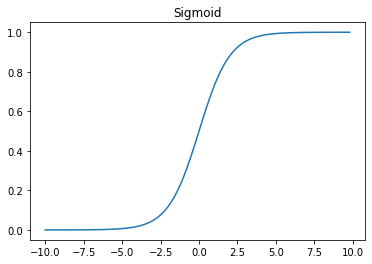

In [108]:
# plot sigmoid activa
x = np.arange(-10., 10., 0.2)

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

sig = sigmoid(x) 
plt.plot(x, sig) 
plt.title("Sigmoid")
plt.show() 

同样地，ReLu也是最常用的激活函数之一，具体形状如下图所示。

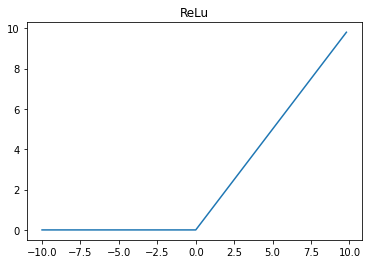

In [109]:
# plot sigmoid activa
x = np.arange(-10., 10., 0.2)

def ReLu(x):
  return np.maximum(0, x)

sig = ReLu(x) 
plt.plot(x, sig) 
plt.title("ReLu")
plt.show() 

### Keras and Tensorflow

Keras是Python中以CNTK、Tensorflow或者Theano为计算后台的一个深度学习建模环境。相对于其他深度学习的框架，如Tensorflow、Theano、Caffe等，Keras在实际应用中有一些显著的优点，其中最主要的优点就是Keras已经高度模块化了，支持现有的常见模型（CNN、RNN等），更重要的是建模过程相当方便快速，加快了开发速度。

这里我们使用以Tensorflow为backend的keras来完成模型构建和训练。

### CNN Model

在介绍了上面的基础知识后，我们可以开始构建模型来完成预测任务了。首先我们使用卷积神经网络 CNN 来尝试解决这个预测任务。

卷积神经网络（convolutional neural network，CNN）是一类强大的、为处理图像数据而设计的神经网络。卷积神经网络需要的参数少于全连接架构的网络，而且卷积也很容易用GPU并行计算。因此卷积神经网络除了能够高效地采样从而获得精确的模型，还能够高效地计算。

久而久之，从业人员越来越多地使用卷积神经网络。即使在通常使用循环神经网络的一维序列结构任务上（例如音频、文本和时间序列分析），卷积神经网络也越来越受欢迎。

因此，对于股票预测这类时间序列分析任务来说，选择采用 CNN 是一个合理的选择。接下来我们使用 keras 来搭建一个简单的卷积神经网络，在代码中，我们给出了详细的解释，并且在最后打印出整体的网络结构。

In [110]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.models import load_model

# Build the model
model = Sequential()
# we choose Conv1D, because the input is a series of data (1 Dimension)
model.add(Conv1D(3, 3, strides=1, activation='relu', input_shape=(MA, 1)))
model.add(Flatten())
model.add(Dense(40, activation='sigmoid'))
# finally, wo must get one predicted price
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 28, 3)             12        
                                                                 
 flatten_7 (Flatten)         (None, 84)                0         
                                                                 
 dense_20 (Dense)            (None, 40)                3400      
                                                                 
 dense_21 (Dense)            (None, 1)                 41        
                                                                 
Total params: 3,453
Trainable params: 3,453
Non-trainable params: 0
_________________________________________________________________
None


为了能够使用卷积算子来处理一维数据，我们需要将输入数据进行简单的变换处理。将其 shape 变为 (Sample, Timestep, Features)
* Sample：  数据量
* Timestep： MA
* Features:  1 (这里只选择了 Close Price 这一个特征列)

经验发现，选择 32 个 epoch 就能够较好地收敛了，因此将 epoch 设置为 32。同时对于时序数据，一般不会以选择 shuffle，将其设置为 False

In [111]:
# Reshape data for (Sample, Timestep, Features) 
X_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
X_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
model.fit(X_train, y_train, epochs=32, validation_data=(X_test, y_test), shuffle=False, verbose=2)    

Epoch 1/32
70/70 - 2s - loss: 0.1287 - val_loss: 12173.1035 - 2s/epoch - 22ms/step
Epoch 2/32
70/70 - 0s - loss: 0.0772 - val_loss: 12141.8809 - 167ms/epoch - 2ms/step
Epoch 3/32
70/70 - 0s - loss: 0.0458 - val_loss: 12116.3857 - 170ms/epoch - 2ms/step
Epoch 4/32
70/70 - 0s - loss: 0.0245 - val_loss: 12102.2393 - 171ms/epoch - 2ms/step
Epoch 5/32
70/70 - 0s - loss: 0.0132 - val_loss: 12094.2207 - 147ms/epoch - 2ms/step
Epoch 6/32
70/70 - 0s - loss: 0.0082 - val_loss: 12089.1484 - 162ms/epoch - 2ms/step
Epoch 7/32
70/70 - 0s - loss: 0.0056 - val_loss: 12085.7412 - 157ms/epoch - 2ms/step
Epoch 8/32
70/70 - 0s - loss: 0.0042 - val_loss: 12083.3369 - 151ms/epoch - 2ms/step
Epoch 9/32
70/70 - 0s - loss: 0.0034 - val_loss: 12081.6045 - 151ms/epoch - 2ms/step
Epoch 10/32
70/70 - 0s - loss: 0.0029 - val_loss: 12080.3408 - 150ms/epoch - 2ms/step
Epoch 11/32
70/70 - 0s - loss: 0.0026 - val_loss: 12079.4180 - 152ms/epoch - 2ms/step
Epoch 12/32
70/70 - 0s - loss: 0.0024 - val_loss: 12078.7471 - 15

在模型训练完成之后，我们利用测试集的输入，对其进行预测分析，得到模型的预测值。联合真实值，我们可以计算得到 mse。

In [112]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (MSE)
mse = np.mean(((predictions - y_test) ** 2))
print(mse)

8/8 [==============================] - 0s 2ms/step
65.45105755270832


对于这个数据，我们可能没有太直观的感受。因此我们将其可视化，来直观地感受一下 CNN 模型的预测效果。

251


<ipython-input-113-9826a1cec057>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


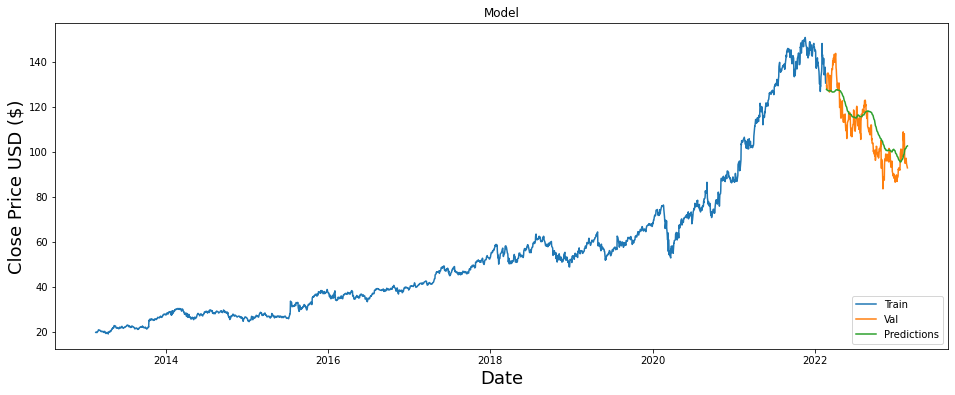

In [113]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
print(len(predictions))
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

可以发现，预测值和真实值的发展趋势是吻合的，但是明显看出，预测值的曲线太过于简单，表达能力不足以去完全拟合每天都会不停变化的股票价格的曲线。

接下来，我们将进行新的尝试，LSTM

### LSTM Model

循环神经网络（Recurrent Neural Network，RNN）是一种用于处理序列数据的神经网络。相比一般的神经网络来说，他能够处理序列变化的数据。比如某个单词的意思会因为上文提到的内容不同而有不同的含义，RNN就能够很好地解决这类问题。  

Long short-term memory - LSTM，是一种特殊的RNN，主要是为了解决长序列训练过程中的梯度消失和梯度爆炸问题。简单来说，就是相比普通的RNN，LSTM能够在更长的序列中有更好的表现。

因此我们认为，选择 LSTM 模型来预测时间序列的变化会是一个不错的选择

同样地，这里我们仍然选择使用 keras 来构建 LSTM 模型。在代码中，我们给出了详细的解释，并且在最后打印出整体的网络结构。

In [114]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()

# there are total 2237 days, so 128 will be a nice try
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
# finally, wo must get one predicted price
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2237/2237 [==============================] - 50s 21ms/step - loss: 0.0013


In [115]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 30, 128)           66560     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_22 (Dense)            (None, 25)                1625      
                                                                 
 dense_23 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [118]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the mean squared error (MSE)
mse = np.mean(((predictions - y_test) ** 2))
print(rmse)

8/8 [==============================] - 0s 20ms/step
4.193515831092373


注意到，最终计算预测值和实际值的 MSE 为 4.19 左右，说明误差已经很小了。

下面我们通过绘图来直观的感受一下预测值和真实结果的拟合情况。

251


<ipython-input-117-9826a1cec057>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


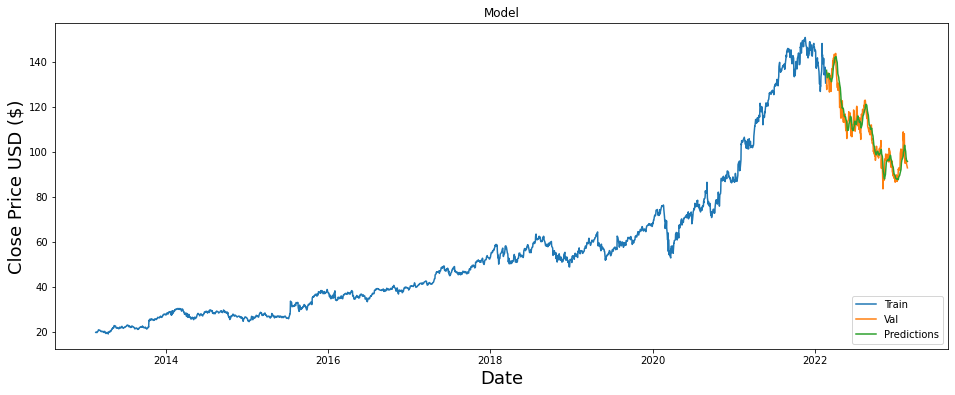

In [117]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
print(len(predictions))
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

我们很明显能够发现，和之前的 CNN 预测模型相比较，LSTM 模型预测能够更好地去拟合真实数据的曲线。当然，本身来说，我们通过 LSTM 预测值计算得到的 MSE 就要比 CNN 的 MSE 要小很多。总的来说， LSTM 在股票价格预测这一任务上有着很不错的表现

## 总结

在这项研究中，我们比较了常用的神经网络模型 CNN 和 LSTM 及其在股价预测任务上的应用。  

我们证明，对于我们给出的网络结构而言，LSTM 模型的表现明显优于 CNN 模型的表现。当然，这可能是由于我们构建的是比较浅层的网络，导致 CNN 的拟合能力还远远不足以去模拟出一条更复杂的曲线。

在训练速度方面，在选择同样的 batch size 的情况下，LSTM 模型训练一个 epoch 大概需要 50s ，而 CNN 模型只需要 0.16s，但是 CNN 模型似乎需要更多的 epoch 来收敛。

这些结果表明，使用 LSTM 来完成股价预测任务会是一个不错的选择。

## Future Work

我们的工作还有可以继续完善的地方：
* 我们可以继续去探索不同的激活函数以及不同的优化函数对于模型的影响
* 我们可以构建更加复杂，更深的卷积神经网络，使其具有更好的拟合能力，也许在耗费更多计算资源的条件下， CNN 会有不错的表现
* 我们还可以继续探索 CNN + LSTM 的组合模型，结合 CNN 的局部理解能力以及 LSTM 对于时间序列的理解能力，可能会在股价预测任务上有更棒的表现。